# Blackjack MC Control with Episilon-greedy Search
## Algorithm
![mc_control](../images/lecture_2/mc_control.png)


## Import Env

In [1]:
import gymnasium as gym
from gymnasium.envs.toy_text.blackjack import BlackjackEnv
for k,v in gym.envs.registry.items():
    print(str(k)+"\t"+str(v))

CartPole-v0	EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
CartPole-v1	EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')
MountainCar-v0	EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.

In [2]:
env=gym.make("Blackjack-v1")

In [3]:
env.env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [4]:
env.action_space.n

2

## Epsilon-greedy Decision

In [5]:
import numpy as np
from typing import Dict, Tuple


def get_epsilon_greedy_action(q: Dict[Tuple[int, int, int], np.ndarray], state: Tuple[int, int, int], num_actions: int, epsilon: float):
    """
        q is the state-action table
        state is the current state (player_sum,dealer_sum,usable_ace)
    """
    probability = np.ones(num_actions, dtype=np.float32)*epsilon/num_actions
    idx_action_with_max_reward=np.argmax(q[state])
    probability[idx_action_with_max_reward]=1-epsilon+epsilon/num_actions
    return np.random.choice(np.arange(env.action_space.n),p=probability)

## MC Control

In [6]:
from collections import defaultdict


def mc_policy_control(env: gym.Env, num_episodes: int, gamma: float = 0.9, epsilon: float = 0.1):
    """epsilon is the greedy parameter of the algorithm"""
    # q is the state-action table, returns (0.0) when key is not in q.keys()
    q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    state_action_reward_sum=defaultdict(float)
    state_action_reward_cnt=defaultdict(float)
    
    for _ in range(num_episodes):
        # generate an episode
        state = env.reset()[0]
        is_epsode_terminated = False
        t_episode = []
        while not is_epsode_terminated:
            action = get_epsilon_greedy_action(
                q, state, env.action_space.n, epsilon)
            next_state, reward, is_epsode_terminated, is_epsode_truncated, info = env.step(
                action)
            t_episode.append((state, action, reward))
            state = next_state
        
        # state_action mc policy evaluation
        state_action_in_episode=[(t_e[0],t_e[1]) for t_e in t_episode]
        state_action_set=set(state_action_in_episode)
        for s_a in state_action_set:
            first_idx_s_a=state_action_in_episode.index(s_a)
            reward=np.sum([np.power(gamma,i)*e[2] for (i,e) in enumerate(t_episode[first_idx_s_a:])])
            state_action_reward_sum[s_a]+=reward
            state_action_reward_cnt[s_a]+=1
            q[s_a[0]][s_a[1]]=state_action_reward_sum[s_a]/state_action_reward_cnt[s_a]
    
    return q

In [7]:
q=mc_policy_control(env,int(1e5))

In [8]:
q

defaultdict(<function __main__.mc_policy_control.<locals>.<lambda>()>,
            {(11, 10, 0): array([-0.59090909,  0.02340559]),
             (14, 9, 1): array([-0.6       , -0.15168938]),
             (20, 9, 0): array([ 0.7528992, -0.8787234]),
             (15, 7, 0): array([-0.61904762, -0.3937655 ]),
             (4, 6, 0): array([-1.        , -0.03790385]),
             (18, 10, 0): array([-0.24088235, -0.64644809]),
             (19, 8, 0): array([ 0.61508951, -0.88857143]),
             (12, 7, 0): array([-0.52380952, -0.24120375]),
             (15, 10, 0): array([-0.59689922, -0.53832133]),
             (21, 10, 0): array([ 0.89038462, -1.        ]),
             (14, 1, 0): array([-0.87755102, -0.58553879]),
             (19, 10, 0): array([ 0.00845804, -0.7893617 ]),
             (4, 10, 0): array([-0.69230769, -0.37840325]),
             (19, 2, 0): array([ 0.34581105, -0.8       ]),
             (12, 9, 0): array([-0.49090909, -0.38733775]),
             (11, 9, 0): ar

In [9]:
def get_optimal_q(q:Dict[Tuple[int,int,int],np.ndarray],with_ace:int):
    v={}
    for state,action_rewards in q.items():
        if state[2]==with_ace:
            v[state]=action_rewards[np.argmax(action_rewards)]
    return v

In [10]:
v_ace=get_optimal_q(q,with_ace=1)
v_noace=get_optimal_q(q,with_ace=0)

In [11]:
v_ace

{(14, 9, 1): -0.15168937500000004,
 (21, 3, 1): 0.9873737373737373,
 (19, 2, 1): 0.39097744360902253,
 (20, 10, 1): 0.4002828854314003,
 (13, 7, 1): 0.028246153846153838,
 (17, 6, 1): 1.708035422500241e-18,
 (16, 6, 1): -0.07200000000000005,
 (21, 7, 1): 1.0,
 (13, 10, 1): -0.13529403409090904,
 (21, 10, 1): 0.9018952062430323,
 (15, 7, 1): 0.0862232142857143,
 (12, 9, 1): -0.0814186046511628,
 (17, 8, 1): -0.1564864864864865,
 (18, 6, 1): 0.264,
 (18, 4, 1): 0.19444444444444445,
 (20, 6, 1): 0.7241379310344828,
 (20, 8, 1): 0.7456140350877193,
 (16, 9, 1): -0.2234311926605504,
 (13, 3, 1): 0.2280389610389611,
 (21, 8, 1): 0.9843400447427293,
 (21, 1, 1): 0.6770601336302895,
 (16, 10, 1): -0.3029531049250543,
 (14, 5, 1): 0.15310344827586206,
 (15, 10, 1): -0.16616653301886794,
 (17, 10, 1): -0.3111428571428581,
 (20, 3, 1): 0.678082191780822,
 (19, 5, 1): 0.48623853211009177,
 (21, 2, 1): 0.9854014598540146,
 (21, 6, 1): 0.9824120603015075,
 (15, 6, 1): 0.11178947368421059,
 (19, 9, 1

In [12]:
v_noace

{(11, 10, 0): 0.023405590062111795,
 (20, 9, 0): 0.7528991971454059,
 (15, 7, 0): -0.3937655016910939,
 (4, 6, 0): -0.03790384615384615,
 (18, 10, 0): -0.24088235294117646,
 (19, 8, 0): 0.6150895140664961,
 (12, 7, 0): -0.2412037499999999,
 (15, 10, 0): -0.538321327904792,
 (21, 10, 0): 0.8903846153846153,
 (14, 1, 0): -0.5855387931034469,
 (19, 10, 0): 0.008458035133376708,
 (4, 10, 0): -0.3784032467532467,
 (19, 2, 0): 0.34581105169340465,
 (12, 9, 0): -0.3873377491207501,
 (11, 9, 0): 0.1354080604534004,
 (18, 9, 0): -0.18247298919567828,
 (13, 10, 0): -0.4898524300441842,
 (14, 4, 0): -0.26359832635983266,
 (14, 10, 0): -0.5145834068843803,
 (19, 3, 0): 0.4627949183303085,
 (10, 8, 0): 0.09545669291338574,
 (20, 1, 0): 0.15555555555555556,
 (11, 2, 0): 0.18306818181818194,
 (17, 10, 0): -0.47696709585121605,
 (7, 7, 0): -0.1337455958549222,
 (16, 10, 0): -0.5536247624219386,
 (20, 10, 0): 0.413154238073182,
 (12, 1, 0): -0.5139533969010717,
 (9, 4, 0): 0.04637785016286647,
 (15, 3,

In [13]:
import matplotlib.pyplot as plt
import matplotlib
def plot_evaluation(v: Dict[Tuple[int, int, int], float], with_ace: int):
    ks = np.asarray([k for k in v.keys()])
    x_min = np.min(ks[:, 0])
    x_max = np.max(ks[:, 0])
    y_min = np.min(ks[:, 1])
    y_max = np.max(ks[:, 1])
    x_range = np.arange(x_min, x_max+1)
    y_range = np.arange(y_min, y_max+1)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    z = np.apply_along_axis(
        lambda x: v[(x[0], x[1], with_ace)], 2, np.dstack([x_grid, y_grid]))
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    surf=ax.plot_surface(x_grid, y_grid, z,cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    

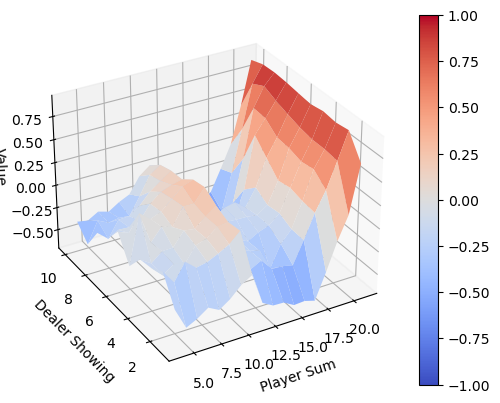

In [14]:
plot_evaluation(v_noace,with_ace=0)

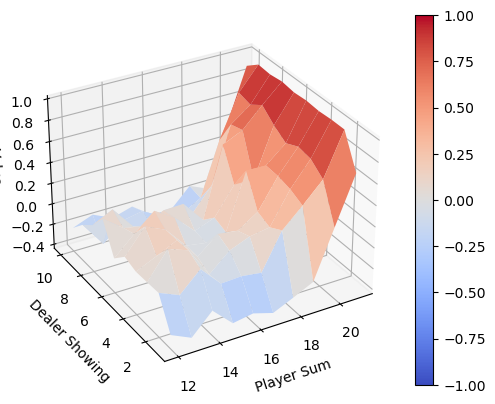

In [15]:
plot_evaluation(v_ace,with_ace=1)

In [22]:
def policy_test(env: gym.Env, q: Dict[Tuple[int, int, int], np.ndarray], num_test: int):
    state = env.reset()[0]
    num_win = 0
    num_loss = 0
    num_tie = 0
    for _ in range(num_test):
        while True:
            action = np.argmax(q[state])
            next_state, reward, is_terminated, truncated, info = env.step(
                action)
            state = next_state
            if is_terminated:
                if reward > 0:
                    num_win += 1
                elif reward < 0:
                    num_loss += 1
                else:
                    num_tie += 1
                state = env.reset()[0]
                break
    print("won %d, loss %d, tied %d of %d games" %
          (num_win, num_loss, num_tie, num_test))

# The win, loss and tie ratio is close to the estimated probability
policy_test(env, q, 1000)


won 426, loss 484, tied 90 of 1000 games
